Full name: Behzad Yousefipour

Student Num: 401300033

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sb
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [3]:
# Data loading:

Data = pd.read_csv("international_matches.csv")
print(Data.tail(10))

             date               home_team            away_team  \
23911  2022-06-14                 Ukraine  Republic of Ireland   
23912  2022-06-14  Bosnia and Herzegovina              Finland   
23913  2022-06-14                 Romania           Montenegro   
23914  2022-06-14              Luxembourg        Faroe Islands   
23915  2022-06-14                  Turkey            Lithuania   
23916  2022-06-14                 Moldova              Andorra   
23917  2022-06-14           Liechtenstein               Latvia   
23918  2022-06-14                   Chile                Ghana   
23919  2022-06-14                   Japan              Tunisia   
23920  2022-06-14          Korea Republic                Egypt   

      home_team_continent away_team_continent  home_team_fifa_rank  \
23911              Europe              Europe                   27   
23912              Europe              Europe                   59   
23913              Europe              Europe                  

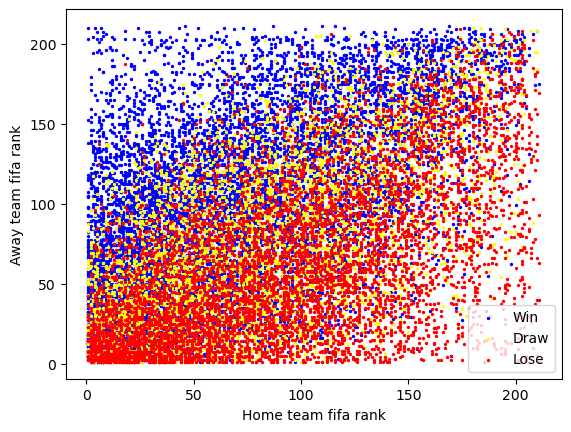

In [6]:
# Scatter plotting:


home_win = Data.loc[Data.home_team_result == 'Win']
x = np.array(home_win.home_team_fifa_rank)
y = np.array(home_win.away_team_fifa_rank)

plt.scatter(x,y, c = "blue", s = 2)


home_draw = Data.loc[Data.home_team_result == 'Draw']
x = np.array(home_draw.home_team_fifa_rank)
y = np.array(home_draw.away_team_fifa_rank)

plt.scatter(x,y, c = "yellow", s = 2)


home_lose = Data.loc[Data.home_team_result == 'Lose']
x = np.array(home_lose.home_team_fifa_rank)
y = np.array(home_lose.away_team_fifa_rank)

plt.scatter(x,y, c = "red", s = 2)
plt.legend(["Win", "Draw", "Lose"], loc ="lower right")
plt.xlabel("Home team fifa rank")
plt.ylabel("Away team fifa rank")

plt.show()

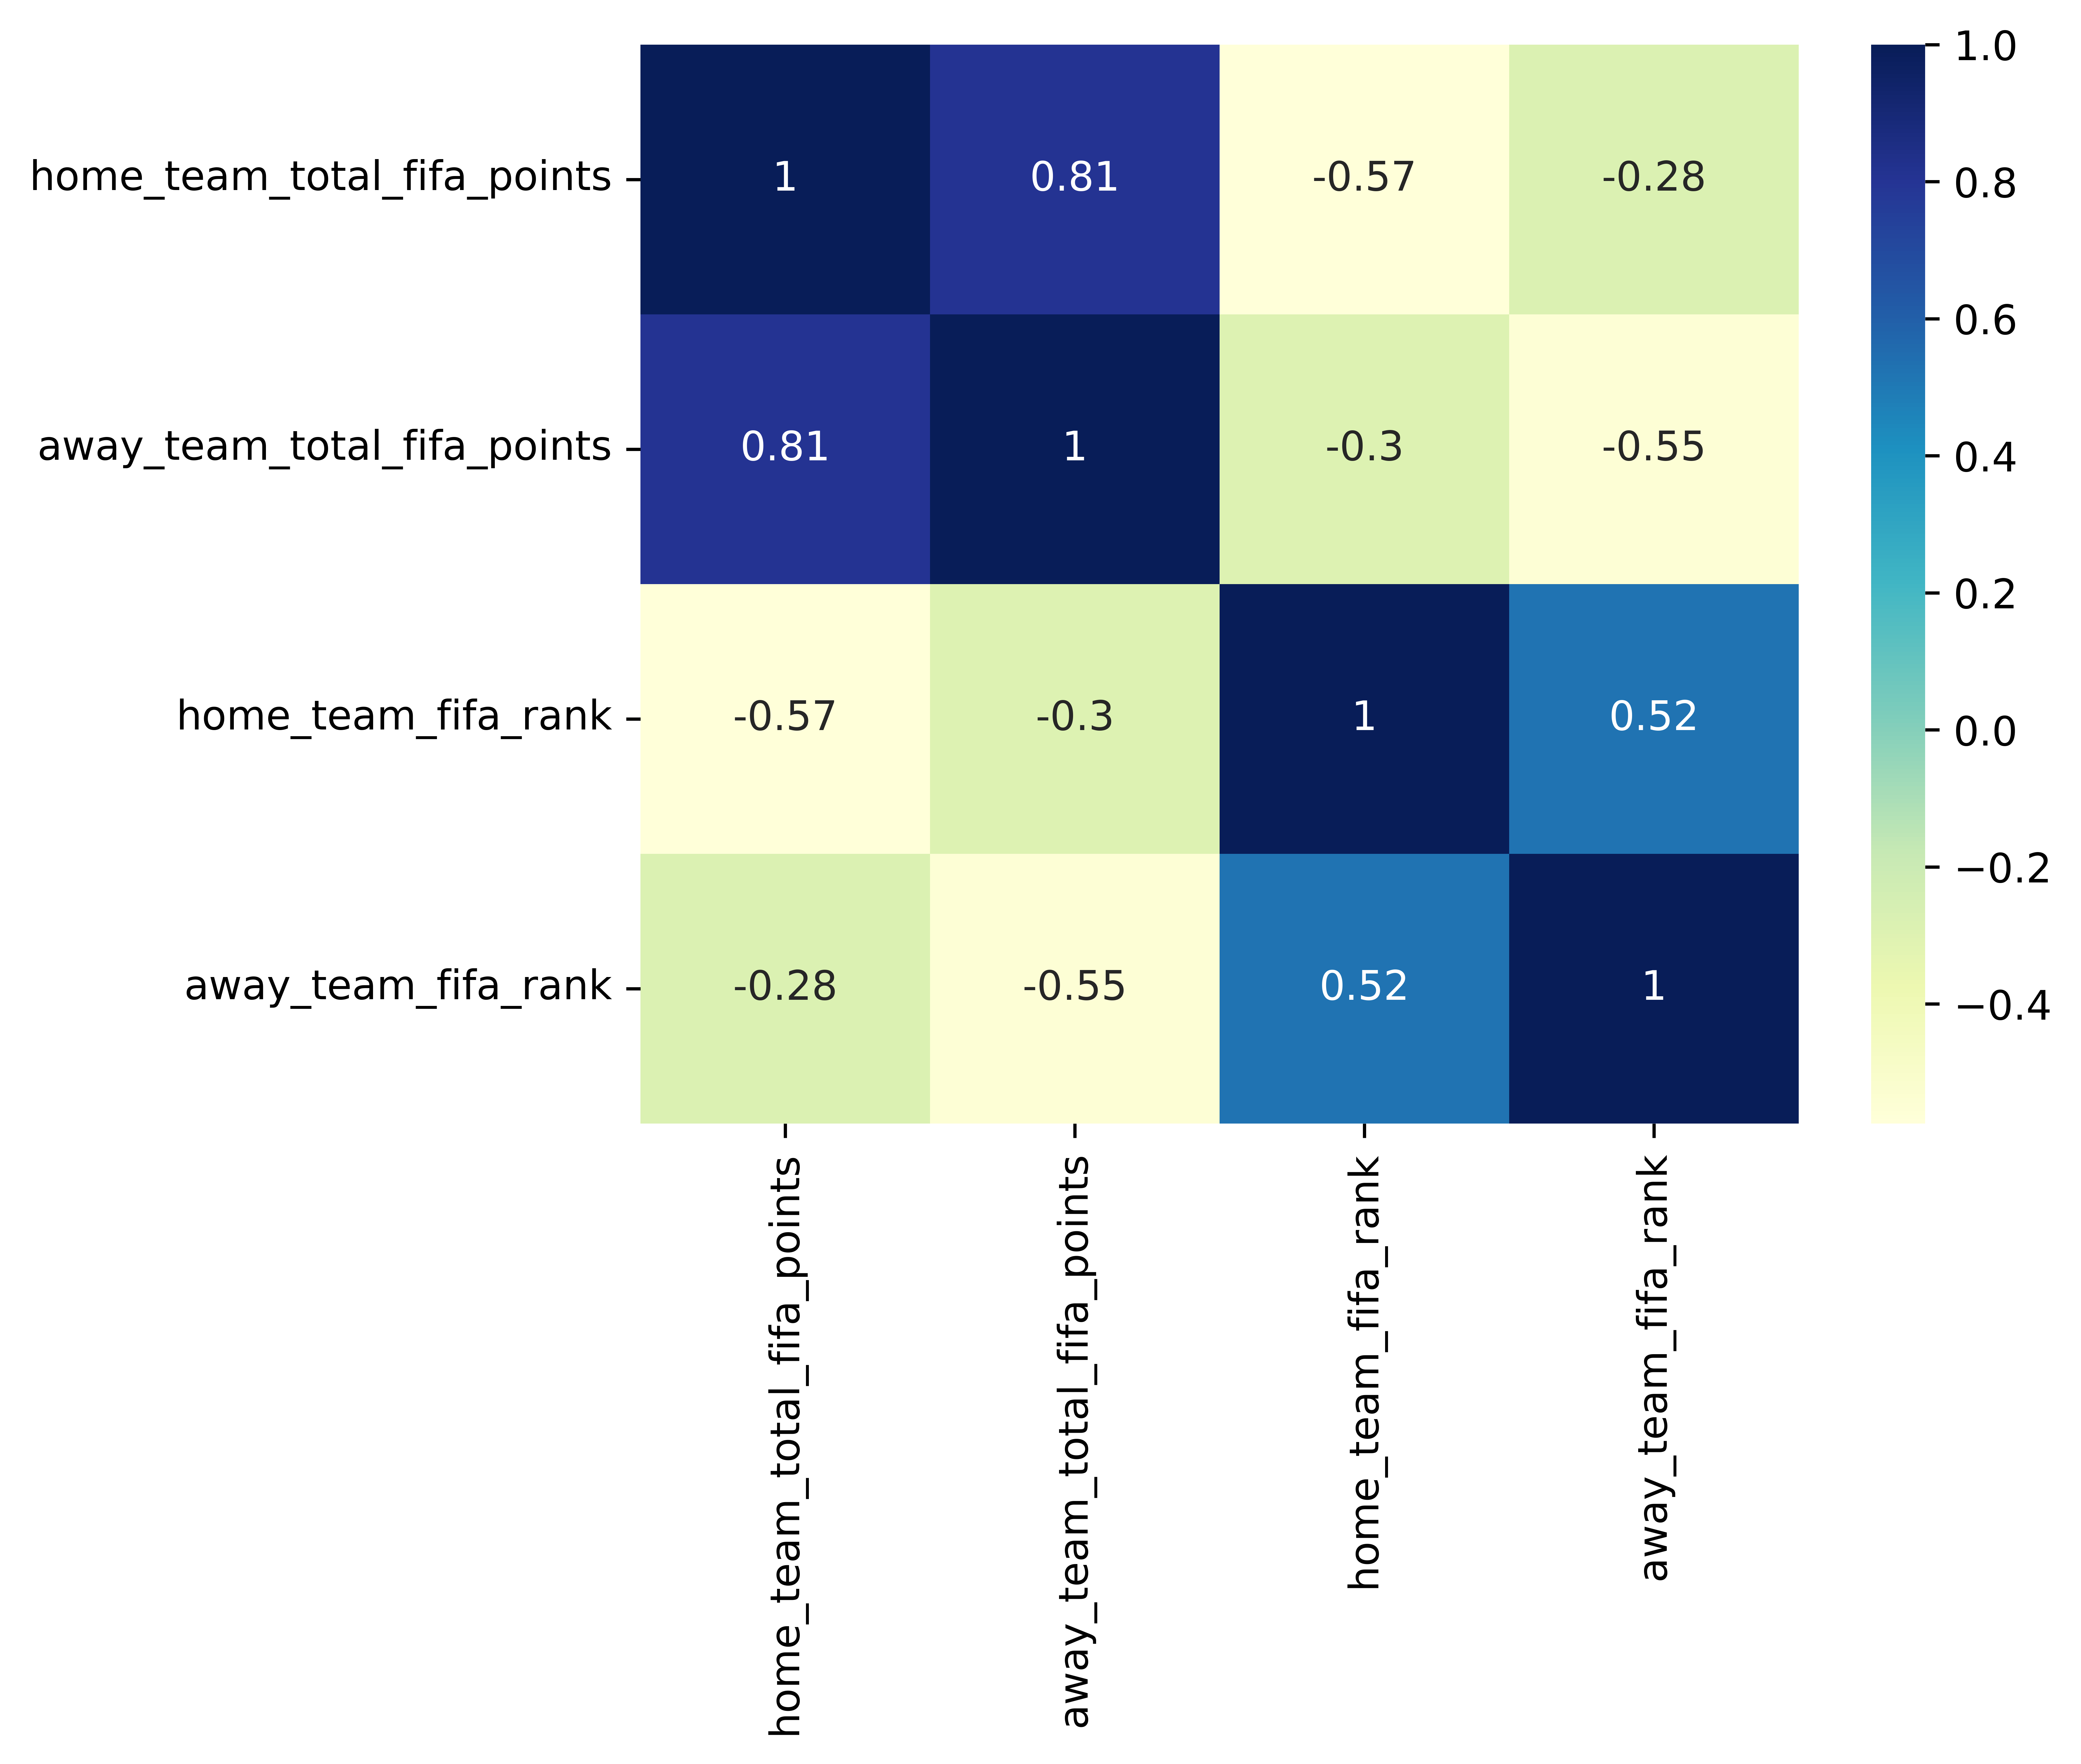

In [9]:
df = Data[Data['home_team_total_fifa_points'] != 0]

df = df[df['away_team_total_fifa_points'] != 0]

label = df.home_team_result

data = {'home_team_total_fifa_points': df.home_team_total_fifa_points,
        'away_team_total_fifa_points': df.away_team_total_fifa_points,
        'home_team_fifa_rank': df.home_team_fifa_rank,
        'away_team_fifa_rank': df.away_team_fifa_rank,
        'label': label}
data = pd.DataFrame(data)

# plotting correlation heatmap
plt.figure(dpi=1000)
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

data_array = np.zeros((len(df),4))
data_array[:,0] = df.home_team_total_fifa_points
data_array[:,1] = df.away_team_total_fifa_points
data_array[:,2] = df.home_team_fifa_rank
data_array[:,3] = df.away_team_fifa_rank

# Train, test split

X_train, X_test, y_train, y_test = train_test_split(data_array, label, test_size=0.25
                                                    ,shuffle=True)


y_tr = np.zeros((len(y_train),1))
y_te = np.zeros((len(y_test),1))
n = 0

for i in y_train:
    if i == 'Win':
        y_tr[n] = 0
        n += 1
    elif i == 'Draw':
        y_tr[n] = 1
        n += 1
    else:
        y_tr[n] = 2
        n += 1
n = 0

for i in y_test:
    if i == 'Win':
        y_te[n] = 0
        n += 1
    elif i == 'Draw':
        y_te[n] = 1
        n += 1
    else:
        y_te[n] = 2
        n += 1        
y_tr = torch.from_numpy(y_tr)
y_te = torch.from_numpy(y_te)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

traindata = MyDataset(X_train, y_tr)
testdata =  MyDataset(X_test, y_te)   

In [32]:
# Neural  network structure:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


In [31]:
# Hyper params:

learning_rate = 1e-3
batch_size = 64


train_dataloader = DataLoader(traindata, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testdata, batch_size=64, shuffle=True)

In [18]:
# Initialize the loss function and optimizer:

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
# Optimization of NN

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):      
        # Compute prediction and loss
        # X, y = X.to(device), y.to(device)
        pred = model(X.to(torch.float32))
        loss = loss_fn(pred, y.squeeze().to(torch.int64))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            test_loss += loss_fn(pred, y.squeeze().to(torch.int64)).item()
            correct += (pred.argmax(1) == y.squeeze()).type(torch.int64).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.135455  [    0/ 7195]
loss: 1.008582  [ 6400/ 7195]
Test Error: 
 Accuracy: 55.6%, Avg loss: 0.979751 

Epoch 2
-------------------------------
loss: 1.036918  [    0/ 7195]
loss: 1.068318  [ 6400/ 7195]
Test Error: 
 Accuracy: 56.6%, Avg loss: 0.983486 

Epoch 3
-------------------------------
loss: 1.042407  [    0/ 7195]
loss: 1.019588  [ 6400/ 7195]
Test Error: 
 Accuracy: 57.5%, Avg loss: 0.953374 

Epoch 4
-------------------------------
loss: 0.967884  [    0/ 7195]
loss: 0.892543  [ 6400/ 7195]
Test Error: 
 Accuracy: 57.7%, Avg loss: 0.956150 

Epoch 5
-------------------------------
loss: 1.025937  [    0/ 7195]
loss: 1.084167  [ 6400/ 7195]
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.952829 

Epoch 6
-------------------------------
loss: 0.825392  [    0/ 7195]
loss: 0.956662  [ 6400/ 7195]
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.954837 

Epoch 7
-------------------------------
loss: 0.925197  [    0/ 7195]
loss: 0.932557  [ 

In [43]:
#Prediction of result of Iran matches in world cup
# Fifa ranks: Iran = 20, England = 5, USA = 16, Wales = 19

iran = torch.tensor([[1728.47, 1564.61, 5, 20],[1569.82,1564.61, 19, 20],[1564.61, 1627.48 ,20, 16]])

iran_pred = model(iran)

iran_pred.argmax(1)

tensor([0, 0, 2])

This means that Iran loses against England, Iran loses against Wales, and Iran loses against the USA :)